In [15]:
import sys
sys.path.insert(0, '../../')  
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.stats import norm
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from gasp import process_data_for_gasp, create_data_mask, train_gasp, run_gasp, simulate_ssfp, simulate_ssfp_sampling, SSFPParams, responses, simulation, sampling

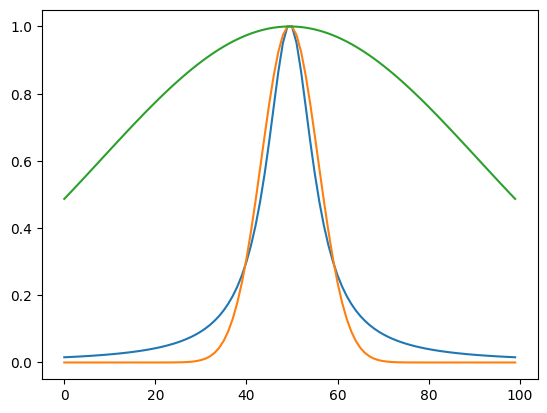

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def lorentzian(width, gamma, shift):
    ''' Lorentzian response curve 
    width: number of pixels of response
    gamma: width parameter (half-width at half-maximum) as fraction of width: 0 to 1
    shift: shift of the peak as fraction of width: -0.5 to 0.5
    '''
    x = np.linspace(-4, 4, width)
    gamma_scaled = gamma * 2  # Scale gamma to match the x range
    y = 1 / (1 + ((x - shift) / (gamma_scaled / 2))**2)
    y = y / np.max(y)  # Normalize the peak to 1
    return y

def gaussian_old(width, bw, shift):
    ''' Gaussian response curve 
    width: number of pixels of response
    bw: width of gaussian: 0 to 1
    shift: shift of bandpass as fraction of width: -0.5 to 0.5
    '''
    sigma = bw / 0.2
    mu = 0
    x = np.linspace(-3, 3, width)
    y = norm.pdf(x, mu, sigma)
    y = np.roll(y, int(shift * width))
    y = y / max(y)
    return y

def gaussian(width, bw, shift):
    ''' Gaussian response curve 
    width: number of pixels of response
    bw: width of gaussian: 0 to 1
    shift: shift of bandpass as fraction of width: -0.5 to 0.5
    '''
    sigma = bw
    mu = 0
    x = np.linspace(-4, 4, width)
    y = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    y = np.roll(y, int(shift * width))
    y = y / max(y)
    return y

plt.plot(lorentzian(100, 0.5, 0))
plt.plot(gaussian(100, 0.5, 0))
plt.plot(gaussian_old(100, 0.5, 0))

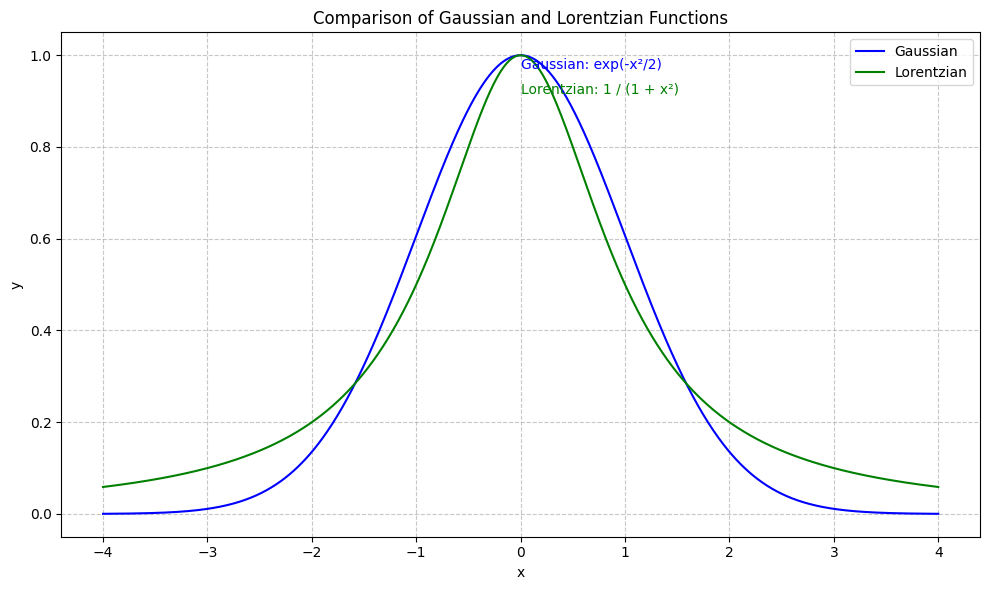

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_model(x, mu=0.0, sigma=1.0):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

def lorentzian(x, x0=0.0, gamma=1.0):
    return 1 / (1 + ((x - x0) / gamma) ** 2)

# Generate x values
x = np.linspace(-4, 4, 1000)

# Calculate y values for Gaussian and Lorentzian
y_gaussian = gaussian_model(x)
y_lorentzian = lorentzian(x)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y_gaussian, label='Gaussian', color='blue')
plt.plot(x, y_lorentzian, label='Lorentzian', color='green')

plt.title('Comparison of Gaussian and Lorentzian Functions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Add text annotations
plt.text(0.5, 0.95, 'Gaussian: exp(-x²/2)', color='blue', ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.5, 0.90, 'Lorentzian: 1 / (1 + x²)', color='green', ha='left', va='top', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

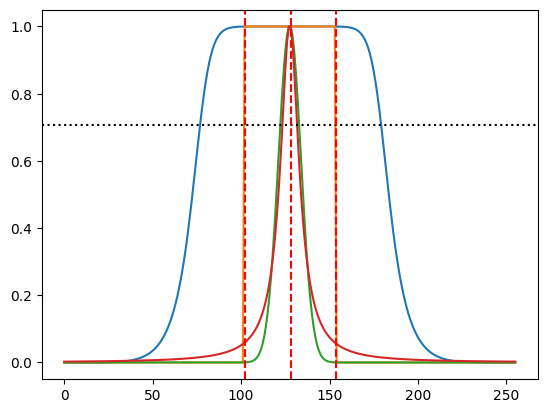

In [27]:
bw = 0.1
width = 256
D = responses.bandpass_filter(width, 0.2, 0)
plt.plot(D) 
D2 = responses.square(width, 0.2, 0)
plt.plot(D2) 
D3 = gaussian(width, 0.2, 0)
plt.plot(D3) 
D4 = lorentzian(width, 0.2, 0)
plt.plot(D4) 

_3db = 10 ** (-3/20)
plt.axhline(_3db, color='k', linestyle=':', label='-3 dB Line')
plt.axvline(width / 2, color='r', linestyle='--', label='Design Lowcut')

shift = 0
fs = width * 2  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # 1 second of data
lowcut =  width * (1/2 - bw + shift) # Lower cutoff frequency (Hz)
highcut = width * (1/2 + bw + shift) # Upper cutoff frequency (Hz)
plt.axvline(lowcut, color='r', linestyle='--', label='Design Lowcut')
plt.axvline(highcut, color='r', linestyle='--', label='Design Lowcut')

plt.show()

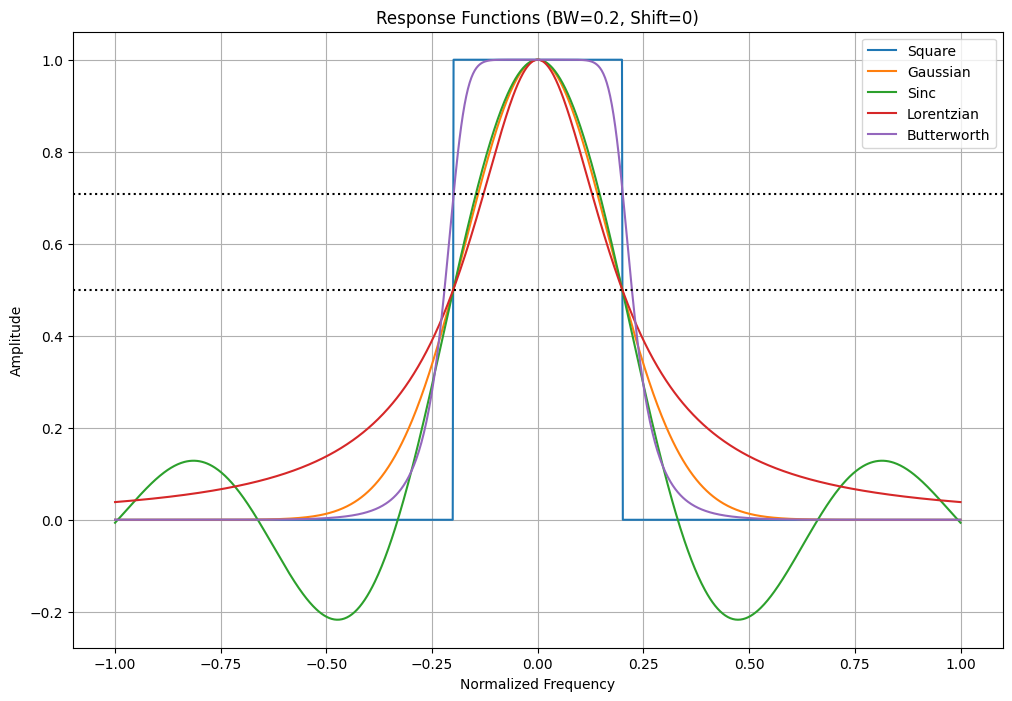

In [109]:
import numpy as np
from scipy import signal
from scipy.stats import norm

def square(width: int, bw: float, shift: float):
    """Square response curve with standardized bandwidth"""
    bw = 2 * bw # scale bandwidth to normalized frequency range
    x = np.linspace(-1, 1, width)
    y = np.zeros(width)
    y[np.abs(x) < bw/2] = 1
    return np.roll(y, int(shift * width))

def gaussian(width: int, bw: float, shift: float):
    """Gaussian response curve with standardized bandwidth"""
    bw = 2 * bw # scale bandwidth to normalized frequency range
    x = np.linspace(-1, 1, width)
    sigma = bw / 2.355 # FWHM = 2.355 * sigma for Gaussian
    y = np.exp(-(x**2) / (2 * sigma**2))
    return np.roll(y, int(shift * width))

def sinc(width: int, bw: float, shift: float):
    """Sinc response curve with standardized bandwidth"""
    bw = 2 * bw # scale bandwidth to normalized frequency range
    x = np.linspace(-1, 1, width)
    # The FWHM of an unscaled sinc is approximately 1.20784
    scale_factor = 1.20784 / bw
    y = np.sinc(x * scale_factor)
    return np.roll(y, int(shift * width))

def lorentzian(width: int, bw: float, shift: float):
    """Lorentzian response curve with standardized bandwidth"""
    bw = 2 * bw # scale bandwidth to normalized frequency range
    x = np.linspace(-1, 1, width)
    gamma = bw / 2 # FWHM = 2 * gamma for Lorentzian
    y = 1 / (1 + (x / gamma)**2)
    return np.roll(y, int(shift * width))

def butterworth(width: int, bw: float, shift: float):
    """butterworth bandpass filter with standardized bandwidth"""
    low = (1 - bw) / 2
    high = (1 + bw) / 2
    b, a = signal.butter(5, [low, high], btype='band')
    w, h = signal.freqz(b, a, worN=width)
    y = np.abs(h)
    return np.roll(y, int(shift * width))

def bandpass(width, bw, shift, type='butterworth'):
    """Bandpass filter with standardized bandwidth"""
    responses = {
        'Square': square(width, bw, shift),
        'Gaussian': gaussian(width, bw, shift),
        'Sinc': sinc(width, bw, shift),
        'Lorentzian': lorentzian(width, bw, shift),
        'Butterworth': butterworth(width, bw, shift)
    }
    return responses[type]

def stopband():
    return 1 - bandpass(width, bw, shift)

# Helper function to normalize responses
def normalize(y):
    return y / np.max(y)

# Function to generate and plot all responses
def plot_all_responses(width: int, bw: float, shift: float):
    x = np.linspace(-1, 1, width)
    responses = {
        'Square': square(width, bw, shift),
        'Gaussian': gaussian(width, bw, shift),
        'Sinc': sinc(width, bw, shift),
        'Lorentzian': lorentzian(width, bw, shift),
        'Butterworth': butterworth(width, bw, shift)
    }
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 8))
    for name, y in responses.items():
        plt.plot(x, normalize(y), label=name)

    plt.legend()
    plt.title(f'Response Functions (BW={bw}, Shift={shift})')
    plt.xlabel('Normalized Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)

    _3db = 10 ** (-3/20)
    plt.axhline(_3db, color='k', linestyle=':', label='-3 dB Line')
    plt.axhline(0.5, color='k', linestyle=':', label='-3 dB Line')

    plt.show()

# Example usage
plot_all_responses(1000, 0.2, 0)